# Tugas Besar Pembelajaran Mesin 2

### Persiapan Data

Hal pertama yang kami lakukan adalah menggunakan data latih Weather Categorization dari WEKA. 

In [1]:
import pandas as pd
import numpy as py

In [2]:
weather_df = pd.read_csv('dataset/weather.csv')

weather_df

,outlook,temperature,humidity,windy,play
0,sunny,85,85,False,no
1,sunny,80,90,True,no
2,overcast,83,86,False,yes
3,rainy,70,96,False,yes
4,rainy,68,80,False,yes
5,rainy,65,70,True,no
6,overcast,64,65,True,yes
7,sunny,72,95,False,no
8,sunny,69,70,False,yes
9,rainy,75,80,False,yes


Dapat dilihat data latih terdiri dari data numerik dan data kategorikal. Diperlukan preprocessing dengan kakas scikit-learn yaitu LabelEncoder sebagai berikut.

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
label_encoder = LabelEncoder()
weather_df['outlook'] = label_encoder.fit_transform(weather_df.outlook)
weather_df['windy'] = label_encoder.fit_transform(weather_df.windy)
weather_df['play'] = label_encoder.fit_transform(weather_df.play)

In [5]:
weather_df

,outlook,temperature,humidity,windy,play
0,2,85,85,0,0
1,2,80,90,1,0
2,0,83,86,0,1
3,1,70,96,0,1
4,1,68,80,0,1
5,1,65,70,1,0
6,0,64,65,1,1
7,2,72,95,0,0
8,2,69,70,0,1
9,1,75,80,0,1


In [6]:
X_weather = weather_df.iloc[:,:4].values
X_weather

array([[ 2, 85, 85,  0],
       [ 2, 80, 90,  1],
       [ 0, 83, 86,  0],
       [ 1, 70, 96,  0],
       [ 1, 68, 80,  0],
       [ 1, 65, 70,  1],
       [ 0, 64, 65,  1],
       [ 2, 72, 95,  0],
       [ 2, 69, 70,  0],
       [ 1, 75, 80,  0],
       [ 2, 75, 70,  1],
       [ 0, 72, 90,  1],
       [ 0, 81, 75,  0],
       [ 1, 71, 91,  1]])

In [7]:
y_weather = weather_df.play.values
y_weather

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

Kemudian, setelah kami menjadikan data latih tersebut numerik, kami melakukan pemisahan sebagian data latih (10%) menjadi data uji dengan proporsi.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_weather, y_weather, test_size=0.1,shuffle=False)

In [10]:
X_train

array([[ 2, 85, 85,  0],
       [ 2, 80, 90,  1],
       [ 0, 83, 86,  0],
       [ 1, 70, 96,  0],
       [ 1, 68, 80,  0],
       [ 1, 65, 70,  1],
       [ 0, 64, 65,  1],
       [ 2, 72, 95,  0],
       [ 2, 69, 70,  0],
       [ 1, 75, 80,  0],
       [ 2, 75, 70,  1],
       [ 0, 72, 90,  1]])

In [11]:
X_test

array([[ 0, 81, 75,  0],
       [ 1, 71, 91,  1]])

In [12]:
y_train

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1])

In [13]:
y_test

array([1, 0])

### Explorasi Keras (1.b)

Pembelajaran akan menggunakan kakas keras dengan model <i>sequential</i> dan lapisan <i>dense</i>.

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


Model akan memakai input layer sebanyak 1 neuron dengan bentuk input 4 sesuai jumlah attribute data latih, kemudian dengan 3 hidden layer masing-masing 2 neuron kemudian 3 neuron, dan 4 neuron dan 1 output layer dengan 1 neuron.

In [15]:
network1 = Sequential()
network1.add(Dense(1, activation='sigmoid', input_shape=(4,)))
network1.add(Dense(2, activation='sigmoid'))
network1.add(Dense(3, activation='sigmoid'))
network1.add(Dense(4, activation='sigmoid'))
network1.add(Dense(1, activation='sigmoid'))

Optimizer yang dipakai adalah Adam (Adaptive Moment Estimation), dengan perhitungan loss dengan Mean Squared Error, dan Metrics Accuracy.

In [16]:
network1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Berikut adalah summary dari model yang akan dipakai.

In [17]:
network1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 5         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


Berikut adalah eksperimen yang dilakukan dengan batch = 1 dan sesuai jumlah data.

<b> Batch = 1 </b>

In [18]:
import time

In [19]:
start = time.time()

In [20]:
history1 = network1.fit(X_train, y_train, epochs=500, verbose=1, batch_size=1, validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/500
10/10 [==============================] - 0s 22ms/step - loss: 0.3832 - acc: 0.4000 - val_loss: 0.5991 - val_acc: 0.0000e+00
Epoch 2/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3782 - acc: 0.4000 - val_loss: 0.5929 - val_acc: 0.0000e+00
Epoch 3/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3749 - acc: 0.4000 - val_loss: 0.5853 - val_acc: 0.0000e+00
Epoch 4/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3718 - acc: 0.4000 - val_loss: 0.5769 - val_acc: 0.0000e+00
Epoch 5/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3676 - acc: 0.4000 - val_loss: 0.5695 - val_acc: 0.0000e+00
Epoch 6/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3643 - acc: 0.4000 - val_loss: 0.5616 - val_acc: 0.0000e+00
Epoch 7/500
10/10 [==============================] - 0s 1ms/step - loss: 0.3605 - acc: 0.4000 - val_loss: 0.5544 - val_acc: 0.0000e+00
Epoch 8/500

Epoch 61/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2570 - acc: 0.4000 - val_loss: 0.2786 - val_acc: 0.0000e+00
Epoch 62/500
10/10 [==============================] - 0s 961us/step - loss: 0.2567 - acc: 0.4000 - val_loss: 0.2748 - val_acc: 0.0000e+00
Epoch 63/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2554 - acc: 0.4000 - val_loss: 0.2725 - val_acc: 0.0000e+00
Epoch 64/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2547 - acc: 0.4000 - val_loss: 0.2711 - val_acc: 0.0000e+00
Epoch 65/500
10/10 [==============================] - 0s 928us/step - loss: 0.2544 - acc: 0.4000 - val_loss: 0.2685 - val_acc: 0.0000e+00
Epoch 66/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2541 - acc: 0.4000 - val_loss: 0.2654 - val_acc: 0.0000e+00
Epoch 67/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2531 - acc: 0.4000 - val_loss: 0.2642 - val_acc: 0.0000e+00
Epoch 68/500
10/10 [========================

10/10 [==============================] - 0s 1ms/step - loss: 0.2419 - acc: 0.6000 - val_loss: 0.1934 - val_acc: 1.0000
Epoch 123/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2420 - acc: 0.6000 - val_loss: 0.1923 - val_acc: 1.0000
Epoch 124/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2416 - acc: 0.6000 - val_loss: 0.1918 - val_acc: 1.0000
Epoch 125/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2415 - acc: 0.6000 - val_loss: 0.1918 - val_acc: 1.0000
Epoch 126/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2415 - acc: 0.6000 - val_loss: 0.1918 - val_acc: 1.0000
Epoch 127/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2415 - acc: 0.6000 - val_loss: 0.1917 - val_acc: 1.0000
Epoch 128/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2414 - acc: 0.6000 - val_loss: 0.1914 - val_acc: 1.0000
Epoch 129/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2415 -

10/10 [==============================] - 0s 1ms/step - loss: 0.2403 - acc: 0.6000 - val_loss: 0.1711 - val_acc: 1.0000
Epoch 184/500
10/10 [==============================] - 0s 980us/step - loss: 0.2403 - acc: 0.6000 - val_loss: 0.1713 - val_acc: 1.0000
Epoch 185/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2404 - acc: 0.6000 - val_loss: 0.1718 - val_acc: 1.0000
Epoch 186/500
10/10 [==============================] - 0s 967us/step - loss: 0.2402 - acc: 0.6000 - val_loss: 0.1712 - val_acc: 1.0000
Epoch 187/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2404 - acc: 0.6000 - val_loss: 0.1702 - val_acc: 1.0000
Epoch 188/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2402 - acc: 0.6000 - val_loss: 0.1702 - val_acc: 1.0000
Epoch 189/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2403 - acc: 0.6000 - val_loss: 0.1698 - val_acc: 1.0000
Epoch 190/500
10/10 [==============================] - 0s 1ms/step - loss: 0.24

10/10 [==============================] - 0s 1ms/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1631 - val_acc: 1.0000
Epoch 245/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1638 - val_acc: 1.0000
Epoch 246/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2402 - acc: 0.6000 - val_loss: 0.1635 - val_acc: 1.0000
Epoch 247/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2402 - acc: 0.6000 - val_loss: 0.1637 - val_acc: 1.0000
Epoch 248/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2403 - acc: 0.6000 - val_loss: 0.1633 - val_acc: 1.0000
Epoch 249/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1637 - val_acc: 1.0000
Epoch 250/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2403 - acc: 0.6000 - val_loss: 0.1627 - val_acc: 1.0000
Epoch 251/500
10/10 [==============================] - 0s 998us/step - loss: 0.2402

10/10 [==============================] - 0s 963us/step - loss: 0.2402 - acc: 0.6000 - val_loss: 0.1613 - val_acc: 1.0000
Epoch 306/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2402 - acc: 0.6000 - val_loss: 0.1605 - val_acc: 1.0000
Epoch 307/500
10/10 [==============================] - 0s 911us/step - loss: 0.2404 - acc: 0.6000 - val_loss: 0.1616 - val_acc: 1.0000
Epoch 308/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1613 - val_acc: 1.0000
Epoch 309/500
10/10 [==============================] - 0s 925us/step - loss: 0.2402 - acc: 0.6000 - val_loss: 0.1606 - val_acc: 1.0000
Epoch 310/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1607 - val_acc: 1.0000
Epoch 311/500
10/10 [==============================] - 0s 989us/step - loss: 0.2402 - acc: 0.6000 - val_loss: 0.1606 - val_acc: 1.0000
Epoch 312/500
10/10 [==============================] - 0s 1ms/step - loss: 

10/10 [==============================] - 0s 983us/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 367/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1602 - val_acc: 1.0000
Epoch 368/500
10/10 [==============================] - 0s 932us/step - loss: 0.2403 - acc: 0.6000 - val_loss: 0.1610 - val_acc: 1.0000
Epoch 369/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1605 - val_acc: 1.0000
Epoch 370/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1609 - val_acc: 1.0000
Epoch 371/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1603 - val_acc: 1.0000
Epoch 372/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1603 - val_acc: 1.0000
Epoch 373/500
10/10 [==============================] - 0s 1ms/step - loss: 0.24

10/10 [==============================] - 0s 1ms/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1598 - val_acc: 1.0000
Epoch 428/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1599 - val_acc: 1.0000
Epoch 429/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1602 - val_acc: 1.0000
Epoch 430/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1596 - val_acc: 1.0000
Epoch 431/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2402 - acc: 0.6000 - val_loss: 0.1603 - val_acc: 1.0000
Epoch 432/500
10/10 [==============================] - 0s 978us/step - loss: 0.2400 - acc: 0.6000 - val_loss: 0.1603 - val_acc: 1.0000
Epoch 433/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2403 - acc: 0.6000 - val_loss: 0.1594 - val_acc: 1.0000
Epoch 434/500
10/10 [==============================] - 0s 2ms/step - loss: 0.2402

10/10 [==============================] - 0s 918us/step - loss: 0.2405 - acc: 0.6000 - val_loss: 0.1608 - val_acc: 1.0000
Epoch 489/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1605 - val_acc: 1.0000
Epoch 490/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1598 - val_acc: 1.0000
Epoch 491/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1601 - val_acc: 1.0000
Epoch 492/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1596 - val_acc: 1.0000
Epoch 493/500
10/10 [==============================] - 0s 998us/step - loss: 0.2401 - acc: 0.6000 - val_loss: 0.1600 - val_acc: 1.0000
Epoch 494/500
10/10 [==============================] - 0s 1ms/step - loss: 0.2402 - acc: 0.6000 - val_loss: 0.1596 - val_acc: 1.0000
Epoch 495/500
10/10 [==============================] - 0s 1ms/step - loss: 0.24

In [21]:
end = time.time() - start

In [22]:
import matplotlib.pyplot as plt

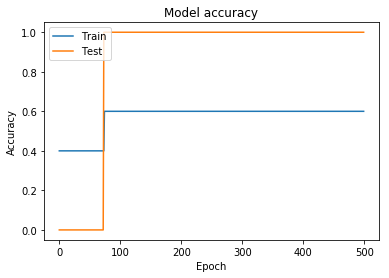

In [23]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

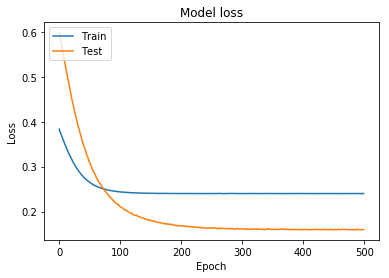

In [24]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
score1 = network1.evaluate(X_test, y_test, batch_size=1)

print("Loss: " + str(score1[0]*100.0) + "%")
print("Accuracy: " + str(score1[1]*100.0) + "%")
print("Time: " + str(end) +" s")

2/2 [==============================] - 0s 1ms/step
Loss: 25.99998190999031%
Accuracy: 50.0%
Time: 6.6286375522613525 s


<b>Batch Size = Jumlah Data Latih</b>

Reinitialisasi model untuk eksperimen kedua.

In [35]:
network2 = Sequential()
network2.add(Dense(1, activation='sigmoid', input_shape=(4,)))
network2.add(Dense(2, activation='sigmoid'))
network2.add(Dense(3, activation='sigmoid'))
network2.add(Dense(4, activation='sigmoid'))
network2.add(Dense(1, activation='sigmoid'))

In [36]:
network2.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [37]:
network2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1)                 5         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 16        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


In [38]:
start = time.time()

In [39]:
history2 = network2.fit(X_train, y_train, epochs=500, verbose=1, batch_size=len(X_train), validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/500
10/10 [==============================] - 0s 34ms/step - loss: 0.3458 - acc: 0.4000 - val_loss: 0.5248 - val_acc: 0.0000e+00
Epoch 2/500
10/10 [==============================] - 0s 248us/step - loss: 0.3453 - acc: 0.4000 - val_loss: 0.5238 - val_acc: 0.0000e+00
Epoch 3/500
10/10 [==============================] - 0s 193us/step - loss: 0.3448 - acc: 0.4000 - val_loss: 0.5225 - val_acc: 0.0000e+00
Epoch 4/500
10/10 [==============================] - 0s 158us/step - loss: 0.3442 - acc: 0.4000 - val_loss: 0.5214 - val_acc: 0.0000e+00
Epoch 5/500
10/10 [==============================] - 0s 261us/step - loss: 0.3437 - acc: 0.4000 - val_loss: 0.5201 - val_acc: 0.0000e+00
Epoch 6/500
10/10 [==============================] - 0s 346us/step - loss: 0.3432 - acc: 0.4000 - val_loss: 0.5189 - val_acc: 0.0000e+00
Epoch 7/500
10/10 [==============================] - 0s 236us/step - loss: 0.3426 - acc: 0.4000 - val_loss: 0.5177 - val_acc: 0.0000e+00

Epoch 61/500
10/10 [==============================] - 0s 154us/step - loss: 0.3145 - acc: 0.4000 - val_loss: 0.4516 - val_acc: 0.0000e+00
Epoch 62/500
10/10 [==============================] - 0s 170us/step - loss: 0.3140 - acc: 0.4000 - val_loss: 0.4504 - val_acc: 0.0000e+00
Epoch 63/500
10/10 [==============================] - 0s 152us/step - loss: 0.3135 - acc: 0.4000 - val_loss: 0.4493 - val_acc: 0.0000e+00
Epoch 64/500
10/10 [==============================] - 0s 162us/step - loss: 0.3130 - acc: 0.4000 - val_loss: 0.4481 - val_acc: 0.0000e+00
Epoch 65/500
10/10 [==============================] - 0s 167us/step - loss: 0.3126 - acc: 0.4000 - val_loss: 0.4469 - val_acc: 0.0000e+00
Epoch 66/500
10/10 [==============================] - 0s 176us/step - loss: 0.3121 - acc: 0.4000 - val_loss: 0.4457 - val_acc: 0.0000e+00
Epoch 67/500
10/10 [==============================] - 0s 193us/step - loss: 0.3116 - acc: 0.4000 - val_loss: 0.4445 - val_acc: 0.0000e+00
Epoch 68/500
10/10 [==============

Epoch 121/500
10/10 [==============================] - 0s 192us/step - loss: 0.2886 - acc: 0.4000 - val_loss: 0.3838 - val_acc: 0.0000e+00
Epoch 122/500
10/10 [==============================] - 0s 172us/step - loss: 0.2882 - acc: 0.4000 - val_loss: 0.3828 - val_acc: 0.0000e+00
Epoch 123/500
10/10 [==============================] - 0s 212us/step - loss: 0.2878 - acc: 0.4000 - val_loss: 0.3817 - val_acc: 0.0000e+00
Epoch 124/500
10/10 [==============================] - 0s 183us/step - loss: 0.2874 - acc: 0.4000 - val_loss: 0.3806 - val_acc: 0.0000e+00
Epoch 125/500
10/10 [==============================] - 0s 167us/step - loss: 0.2871 - acc: 0.4000 - val_loss: 0.3796 - val_acc: 0.0000e+00
Epoch 126/500
10/10 [==============================] - 0s 140us/step - loss: 0.2867 - acc: 0.4000 - val_loss: 0.3786 - val_acc: 0.0000e+00
Epoch 127/500
10/10 [==============================] - 0s 161us/step - loss: 0.2863 - acc: 0.4000 - val_loss: 0.3775 - val_acc: 0.0000e+00
Epoch 128/500
10/10 [======

Epoch 180/500
10/10 [==============================] - 0s 195us/step - loss: 0.2697 - acc: 0.4000 - val_loss: 0.3266 - val_acc: 0.0000e+00
Epoch 181/500
10/10 [==============================] - 0s 344us/step - loss: 0.2694 - acc: 0.4000 - val_loss: 0.3257 - val_acc: 0.0000e+00
Epoch 182/500
10/10 [==============================] - 0s 295us/step - loss: 0.2691 - acc: 0.4000 - val_loss: 0.3248 - val_acc: 0.0000e+00
Epoch 183/500
10/10 [==============================] - 0s 299us/step - loss: 0.2689 - acc: 0.4000 - val_loss: 0.3240 - val_acc: 0.0000e+00
Epoch 184/500
10/10 [==============================] - 0s 311us/step - loss: 0.2686 - acc: 0.4000 - val_loss: 0.3231 - val_acc: 0.0000e+00
Epoch 185/500
10/10 [==============================] - 0s 344us/step - loss: 0.2684 - acc: 0.4000 - val_loss: 0.3222 - val_acc: 0.0000e+00
Epoch 186/500
10/10 [==============================] - 0s 267us/step - loss: 0.2681 - acc: 0.4000 - val_loss: 0.3214 - val_acc: 0.0000e+00
Epoch 187/500
10/10 [======

Epoch 239/500
10/10 [==============================] - 0s 180us/step - loss: 0.2570 - acc: 0.4000 - val_loss: 0.2805 - val_acc: 0.0000e+00
Epoch 240/500
10/10 [==============================] - 0s 191us/step - loss: 0.2568 - acc: 0.4000 - val_loss: 0.2799 - val_acc: 0.0000e+00
Epoch 241/500
10/10 [==============================] - 0s 291us/step - loss: 0.2566 - acc: 0.4000 - val_loss: 0.2792 - val_acc: 0.0000e+00
Epoch 242/500
10/10 [==============================] - 0s 242us/step - loss: 0.2565 - acc: 0.4000 - val_loss: 0.2785 - val_acc: 0.0000e+00
Epoch 243/500
10/10 [==============================] - 0s 183us/step - loss: 0.2563 - acc: 0.4000 - val_loss: 0.2778 - val_acc: 0.0000e+00
Epoch 244/500
10/10 [==============================] - 0s 164us/step - loss: 0.2562 - acc: 0.4000 - val_loss: 0.2772 - val_acc: 0.0000e+00
Epoch 245/500
10/10 [==============================] - 0s 204us/step - loss: 0.2560 - acc: 0.4000 - val_loss: 0.2765 - val_acc: 0.0000e+00
Epoch 246/500
10/10 [======

Epoch 299/500
10/10 [==============================] - 0s 760us/step - loss: 0.2491 - acc: 0.6000 - val_loss: 0.2448 - val_acc: 1.0000
Epoch 300/500
10/10 [==============================] - 0s 228us/step - loss: 0.2490 - acc: 0.6000 - val_loss: 0.2443 - val_acc: 1.0000
Epoch 301/500
10/10 [==============================] - 0s 186us/step - loss: 0.2489 - acc: 0.6000 - val_loss: 0.2438 - val_acc: 1.0000
Epoch 302/500
10/10 [==============================] - 0s 177us/step - loss: 0.2488 - acc: 0.6000 - val_loss: 0.2433 - val_acc: 1.0000
Epoch 303/500
10/10 [==============================] - 0s 179us/step - loss: 0.2487 - acc: 0.6000 - val_loss: 0.2428 - val_acc: 1.0000
Epoch 304/500
10/10 [==============================] - 0s 157us/step - loss: 0.2486 - acc: 0.6000 - val_loss: 0.2423 - val_acc: 1.0000
Epoch 305/500
10/10 [==============================] - 0s 143us/step - loss: 0.2485 - acc: 0.6000 - val_loss: 0.2418 - val_acc: 1.0000
Epoch 306/500
10/10 [==============================] - 

Epoch 360/500
10/10 [==============================] - 0s 187us/step - loss: 0.2446 - acc: 0.6000 - val_loss: 0.2182 - val_acc: 1.0000
Epoch 361/500
10/10 [==============================] - 0s 305us/step - loss: 0.2445 - acc: 0.6000 - val_loss: 0.2178 - val_acc: 1.0000
Epoch 362/500
10/10 [==============================] - 0s 219us/step - loss: 0.2445 - acc: 0.6000 - val_loss: 0.2175 - val_acc: 1.0000
Epoch 363/500
10/10 [==============================] - 0s 167us/step - loss: 0.2444 - acc: 0.6000 - val_loss: 0.2171 - val_acc: 1.0000
Epoch 364/500
10/10 [==============================] - 0s 182us/step - loss: 0.2444 - acc: 0.6000 - val_loss: 0.2168 - val_acc: 1.0000
Epoch 365/500
10/10 [==============================] - 0s 197us/step - loss: 0.2443 - acc: 0.6000 - val_loss: 0.2164 - val_acc: 1.0000
Epoch 366/500
10/10 [==============================] - 0s 185us/step - loss: 0.2442 - acc: 0.6000 - val_loss: 0.2160 - val_acc: 1.0000
Epoch 367/500
10/10 [==============================] - 

Epoch 421/500
10/10 [==============================] - 0s 161us/step - loss: 0.2422 - acc: 0.6000 - val_loss: 0.1992 - val_acc: 1.0000
Epoch 422/500
10/10 [==============================] - 0s 189us/step - loss: 0.2421 - acc: 0.6000 - val_loss: 0.1990 - val_acc: 1.0000
Epoch 423/500
10/10 [==============================] - 0s 226us/step - loss: 0.2421 - acc: 0.6000 - val_loss: 0.1987 - val_acc: 1.0000
Epoch 424/500
10/10 [==============================] - 0s 173us/step - loss: 0.2421 - acc: 0.6000 - val_loss: 0.1985 - val_acc: 1.0000
Epoch 425/500
10/10 [==============================] - 0s 139us/step - loss: 0.2421 - acc: 0.6000 - val_loss: 0.1982 - val_acc: 1.0000
Epoch 426/500
10/10 [==============================] - 0s 155us/step - loss: 0.2420 - acc: 0.6000 - val_loss: 0.1980 - val_acc: 1.0000
Epoch 427/500
10/10 [==============================] - 0s 191us/step - loss: 0.2420 - acc: 0.6000 - val_loss: 0.1977 - val_acc: 1.0000
Epoch 428/500
10/10 [==============================] - 

Epoch 482/500
10/10 [==============================] - 0s 186us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1860 - val_acc: 1.0000
Epoch 483/500
10/10 [==============================] - 0s 323us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1858 - val_acc: 1.0000
Epoch 484/500
10/10 [==============================] - 0s 219us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1856 - val_acc: 1.0000
Epoch 485/500
10/10 [==============================] - 0s 194us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1854 - val_acc: 1.0000
Epoch 486/500
10/10 [==============================] - 0s 149us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1853 - val_acc: 1.0000
Epoch 487/500
10/10 [==============================] - 0s 181us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1851 - val_acc: 1.0000
Epoch 488/500
10/10 [==============================] - 0s 195us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1849 - val_acc: 1.0000
Epoch 489/500
10/10 [==============================] - 

In [40]:
end = time.time() - start

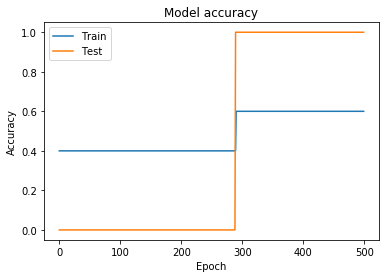

In [41]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

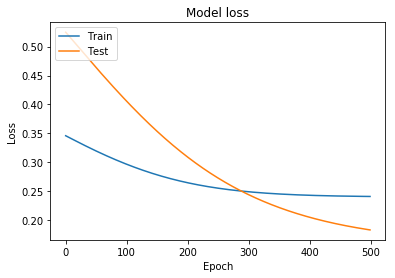

In [42]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [43]:
score2 = network2.evaluate(X_test, y_test, batch_size=len(X_train))

print("Loss: " + str(score2[0]*100.0) + "%")
print("Accuracy: " + str(score2[1]*100.0) + "%")
print("Time: " + str(end) +" s")

2/2 [==============================] - 0s 489us/step
Loss: 25.523075461387634%
Accuracy: 50.0%
Time: 2.1943225860595703 s
